In [ ]:
# Imports

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms



In [ ]:
# Configuration and hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# VAE hyperparameters
vae_latent_dim = 16
vae_hidden_dim = 400
vae_epochs = 5
vae_batch_size = 128
vae_lr = 1e-3

# Diffusion hyperparameters
diffusion_T = 250         # number of diffusion steps
diffusion_epochs = 50
diffusion_batch_size = 128
diffusion_lr = 2e-4


Using device: cuda


In [ ]:
# MNIST dataset

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])

train_dataset = datasets.CelebA(
    root='./data',
    download=True,
    split='train',
    transform=transform,
)
test_dataset = datasets.CelebA(
    root='./data',
    download=True,
    split='test',
    transform=transform,
)


train_loader_vae = DataLoader(train_dataset, batch_size=vae_batch_size, shuffle=True)
test_loader_vae = DataLoader(test_dataset, batch_size=vae_batch_size, shuffle=False)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 162770 Test size: 19962


## 1. VAE: MNIST → Latent → MNIST

We use a simple fully-connected VAE:
- Encoder: 784 → 400 → (μ, logσ²) in 16D latent space
- Decoder: 16 → 400 → 784


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 64x32x32
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1), # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 4, 2, 1), # 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 512, 4, 2, 1), # 512x4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )

        # The encoder output is shape: (512, 4, 4) → 512*4*4 = 8192
        self.flat_dim = 512 * 4 * 4

        # Latent parameters
        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, self.flat_dim)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 3x64x64
            nn.Tanh()  # output in [-1,1]
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(z.size(0), 512, 4, 4)
        x_hat = self.decoder_conv(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [ ]:
def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction loss (pixel MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    loss = (recon_loss + kl) / x.size(0)
    return loss, recon_loss / x.size(0), kl / x.size(0)


In [ ]:
vae = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=vae_lr)

print(vae)


VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=8192, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=8192, out_features=64, bias=True)
  (fc_decode): Linear(in_features=64, out_features=8192, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_si

In [ ]:
# Train VAE

vae.train()
for epoch in range(1, vae_epochs + 1):
    total_loss = 0.0
    total_bce = 0.0
    total_kl = 0.0
    n_samples = 0

    for x, _ in train_loader_vae:
        x = x.to(device)

        vae_optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss, bce, kl = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        vae_optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item()
        total_bce += bce.item()
        total_kl += kl.item()
        n_samples += batch_size

    avg_loss = total_loss / n_samples
    avg_bce = total_bce / n_samples
    avg_kl = total_kl / n_samples

    print(f"[VAE] Epoch {epoch:02d} | Loss: {avg_loss:.4f} (BCE {avg_bce:.4f}, KL {avg_kl:.4f})")


[VAE] Epoch 01 | Loss: 6.0322 (BCE 5.1392, KL 0.8930)
[VAE] Epoch 02 | Loss: 5.6257 (BCE 4.7102, KL 0.9154)
[VAE] Epoch 03 | Loss: 5.3797 (BCE 4.4465, KL 0.9332)
[VAE] Epoch 04 | Loss: 5.1876 (BCE 4.2425, KL 0.9451)
[VAE] Epoch 05 | Loss: 5.0260 (BCE 4.0690, KL 0.9570)


## Reconstruction

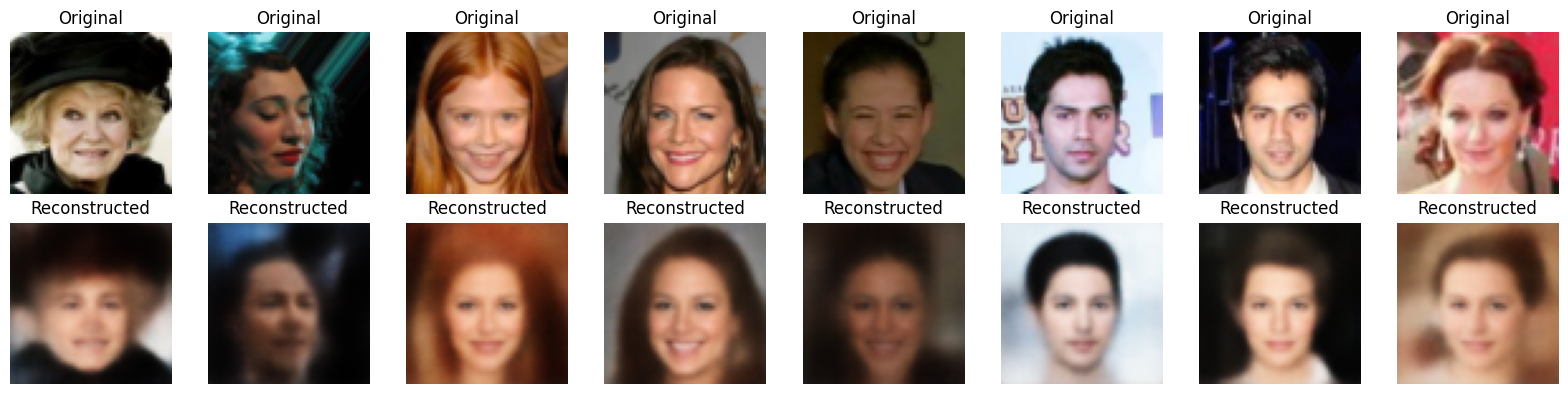

In [ ]:
vae.eval()
x_batch, _ = next(iter(test_loader_vae))   # use your CelebA dataloader
x_batch = x_batch.to(device)

with torch.no_grad():
    x_hat, mu, logvar = vae(x_batch)

# Move to CPU
x_batch = x_batch.cpu()
x_hat = x_hat.cpu()

# Convert from [-1,1] → [0,1] for rendering
x_batch = (x_batch + 1) / 2
x_hat = (x_hat + 1) / 2

# Plot
n = 8
plt.figure(figsize=(2 * n, 4))

for i in range(n):
    # -----------------------------
    # ORIGINAL
    # -----------------------------
    plt.subplot(2, n, i + 1)
    plt.imshow(x_batch[i].permute(1, 2, 0))  # (3,64,64) → (64,64,3)
    plt.axis("off")
    plt.title("Original")

    # -----------------------------
    # RECONSTRUCTION
    # -----------------------------
    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_hat[i].permute(1, 2, 0))
    plt.axis("off")
    plt.title("Reconstructed")

plt.tight_layout()
plt.show()


## Generation

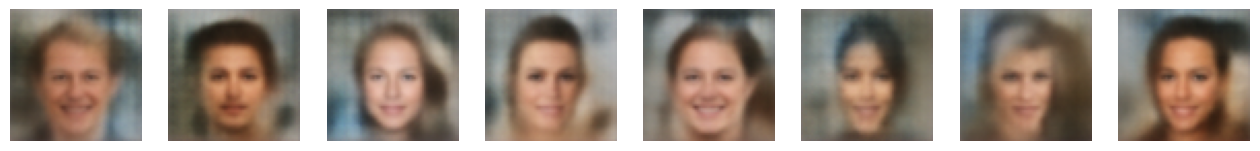

In [ ]:
vae.eval()

latent_dim = vae.fc_mu.out_features   # = 64 in your model

with torch.no_grad():
    # Sample z ~ N(0, I)
    z = torch.randn(32, latent_dim).to(device)

    # Decode to images
    x_gen = vae.decode(z)

# Convert from [-1,1] → [0,1] for display
x_gen = (x_gen.cpu() + 1) / 2

plt.figure(figsize=(16,4))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(x_gen[i].permute(1,2,0))
    plt.axis("off")
plt.show()

